# Support Vector Machines
## Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

## Reading the data
Here we have a dataset that is pretty tough to use with a Support Vector Machine.
THis helps looking at the downsides of these classifiers also.

In [2]:
data = pd.read_csv("../Datasets/games.csv")
data.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


## Information about the data
We don't have any missing values, which is a good. <br>
We don't need the "id","white_id","black_id" as it doesn't contribute to classification
<br>We will be converting "victory_status" to numeric value along with the "winner"<br>
"Winner" will be our target.<br>
The last four columns are going to be removed for now. As they are non-numeric. <br>
As we go further we will see how we can use this.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


## Converting "victory_status" to numeric
We have used the dict as defined below as a map

In [4]:
vals = data["victory_status"].unique()
vic_status = {vals[i]:i for i in range(len(vals))}
data["victory_status"] = data["victory_status"].map(vic_status)
data.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,0,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,1,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,2,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,2,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,2,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


## Converting "winner" to numeric
We have used the dict as defined below as a map

In [5]:
vals = data["winner"].unique()
vals_dict = {vals[i]:i for i in range(len(vals))}
data["winner"] = data["winner"].map(vals_dict)
data.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,0,0,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,1,1,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,2,0,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,2,0,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,2,0,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


## Cleaning up the data 
We drop all the columns specified above. 

In [6]:
headings = data.columns
data_clean = data.drop([headings[0],headings[1],headings[7],headings[8],headings[10],headings[12],headings[13],headings[14],headings[15]],axis = 1)
data_clean.head()

,created_at,last_move_at,turns,victory_status,winner,white_rating,black_rating
0,1.504210e+12,1.504210e+12,13,0,0,1500,1191
1,1.504130e+12,1.504130e+12,16,1,1,1322,1261
2,1.504130e+12,1.504130e+12,61,2,0,1496,1500
3,1.504110e+12,1.504110e+12,61,2,0,1439,1454
4,1.504030e+12,1.504030e+12,95,2,0,1523,1469


## Statistics of the cleaned data
We can see that normalizing the created_at and the loast_move_at is required. 
<br>We do not normalize the turns column.<br>
We do normalize the white_rating and black_rating because they are in a range (Accoring to the game the data was collected from)

In [7]:
data_clean.describe()

,created_at,last_move_at,turns,victory_status,winner,white_rating,black_rating
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1.321916,0.548759,1596.631868,1588.831987
std,2.850151e+10,2.850140e+10,33.570585,0.690045,0.585120,291.253376,291.036126
min,1.376772e+12,1.376772e+12,1.000000,0.000000,0.000000,784.000000,789.000000
25%,1.477548e+12,1.477548e+12,37.000000,1.000000,0.000000,1398.000000,1391.000000
50%,1.496010e+12,1.496010e+12,55.000000,1.000000,1.000000,1567.000000,1562.000000
75%,1.503170e+12,1.503170e+12,79.000000,2.000000,1.000000,1793.000000,1784.000000
max,1.504493e+12,1.504494e+12,349.000000,3.000000,2.000000,2700.000000,2723.000000


## Normalize the data

In [8]:
headings = data_clean.columns
for i in [0,1,5,6]:
    data_clean[headings[i]] = (data_clean[headings[i]] - data_clean[headings[i]].mean())/data_clean[headings[i]].std()

## Statistics of normalized data

In [9]:
data_clean.describe()

,created_at,last_move_at,turns,victory_status,winner,white_rating,black_rating
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,2.005800e+04,2.005800e+04
mean,1.128136e-14,-7.996206e-14,60.465999,1.321916,0.548759,-2.093472e-16,-2.234339e-16
std,1.000000e+00,1.000000e+00,33.570585,0.690045,0.585120,1.000000e+00,1.000000e+00
min,-3.748757e+00,-3.748793e+00,1.000000,0.000000,0.000000,-2.790120e+00,-2.748222e+00
25%,-2.129485e-01,-2.129798e-01,37.000000,1.000000,0.000000,-6.819899e-01,-6.797506e-01
50%,4.348242e-01,4.347954e-01,55.000000,1.000000,1.000000,-1.017391e-01,-9.219470e-02
75%,6.860390e-01,6.860111e-01,79.000000,2.000000,1.000000,6.742175e-01,6.705972e-01
max,7.324627e-01,7.324589e-01,349.000000,3.000000,2.000000,3.788345e+00,3.897001e+00


## Seperating the target and the features data

In [10]:
data_Y = data_clean["winner"]
data_X = data_clean.drop(["winner"],axis = 1)

## Population size
We have about 20,000 records and about 6 features

In [11]:
print(data_X.shape,data_Y.shape)

(20058, 6) (20058,)


## Visualize correlation of data
We can see that the first two columns are co-related because they are timings.<br>
Naturally as we increase the start time the end times also increase<br>
The white and black ratings are also co-related because of the ame mechanics.<br>
It matches players with same or similar In game rating to ensure everyone has a good time

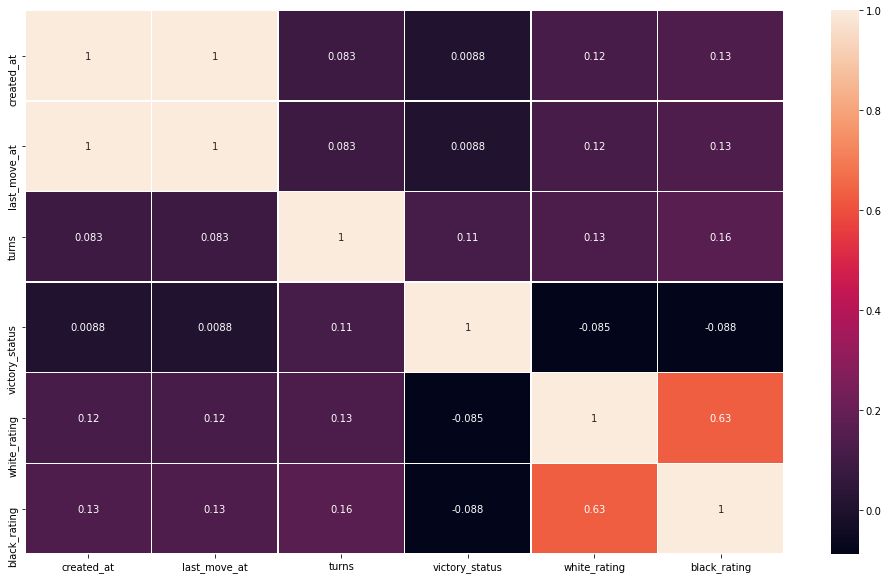

In [12]:
plt.figure(figsize = (17,10))
corr = data_X.corr()
sns.heatmap(corr,annot = True,linewidth = 0.5)

## Visualizing class distribution
Almost uniform. Except for the draw that takes away from both the classes.
<br> Baseline accuracy for a majority classifier will be about 50% (Approximate)

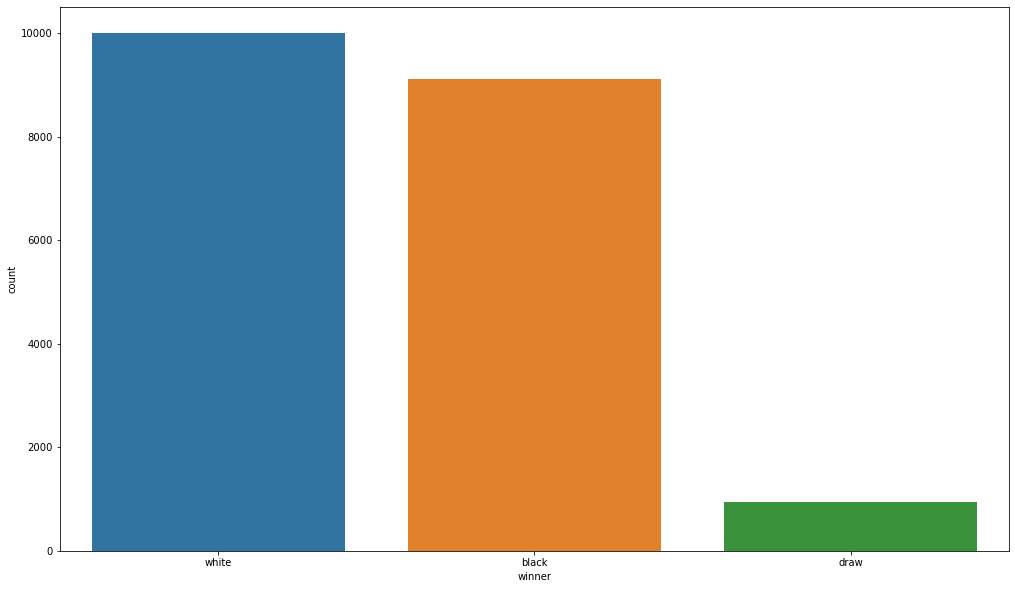

In [13]:
plt.figure(figsize = (17,10))
temp = {v: k for k, v in vals_dict.items()}
sns.countplot(data_Y.map(temp))

## Visualizing attributes
Here we can see how many attributes actually contribute effectively to classification<br>
We see that almost none of the features contribute to the classification


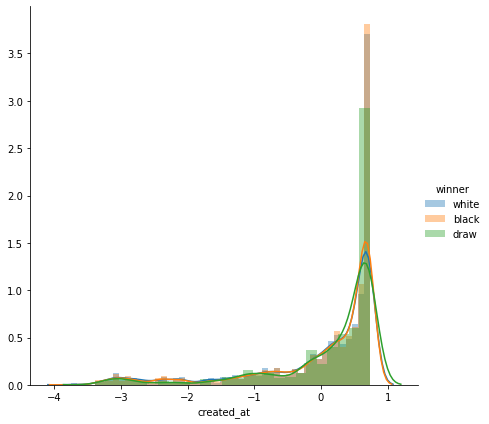

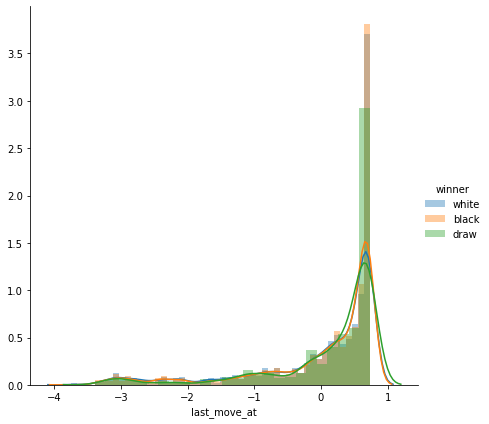

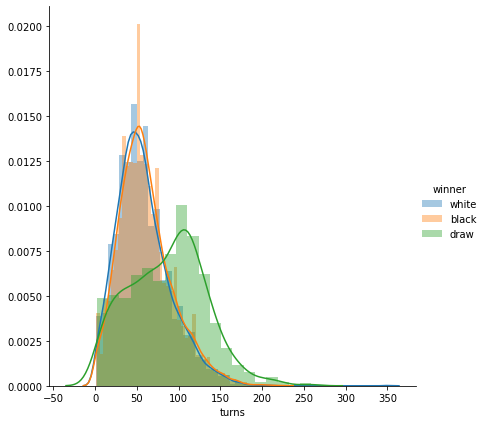

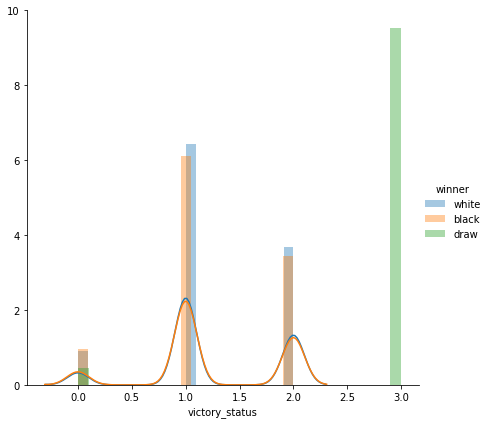

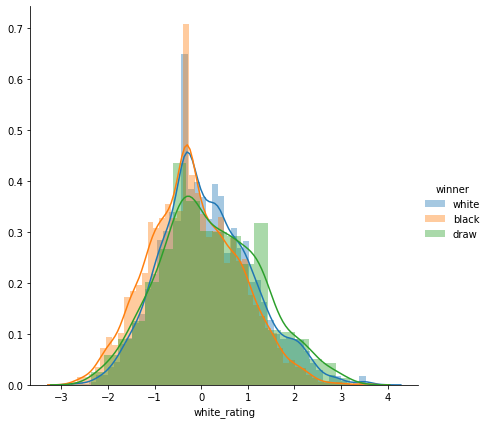

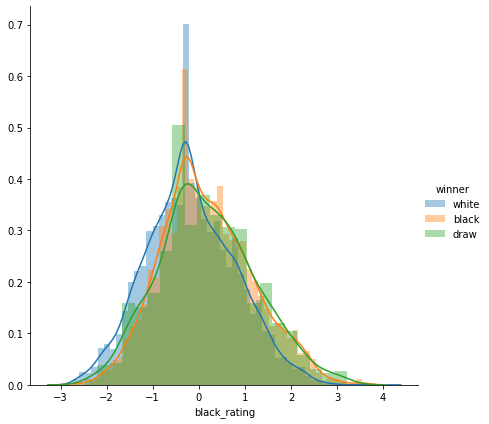

In [14]:
temp = pd.concat((data_X,data_Y.map({v: k for k, v in vals_dict.items()})),axis = 1)
for col in temp.columns[:-1]:
    g = sns.FacetGrid(temp,hue = "winner",height = 6)
    g.map(sns.distplot,col).add_legend()

## Seperating into train and test splits

In [15]:
X_train,X_test,Y_train,Y_test = train_test_split(data_X,data_Y,test_size = 0.2)

## Sanity checking the dimensions

In [16]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(16046, 6) (16046,)
(4012, 6) (4012,)


## Support vector machines without regularization
Suport vector machines are a version of large margin classifiers that allow some misclassification to increase overall accuracy.<br>
In this case, we are using no regularization. Technically you cannot have "C"<=0 because support vector classifiers have to have some amount of regularization.<br>
We have used 0.01e-7 as the "C" parameter. SO very close to zero.<br>
We have used the kernel as "linear"<br>
A kernel here means that the SVM does not use any other features than the given ones. <br>
A kernel is usually used to create more features by using the given features to increase accruacy.<br>
The classifier behaves as expected. Same as majority clasifier. As we have n good features

Train Accuracy:  49.8628941792347
Test accuracy:  49.85044865403789


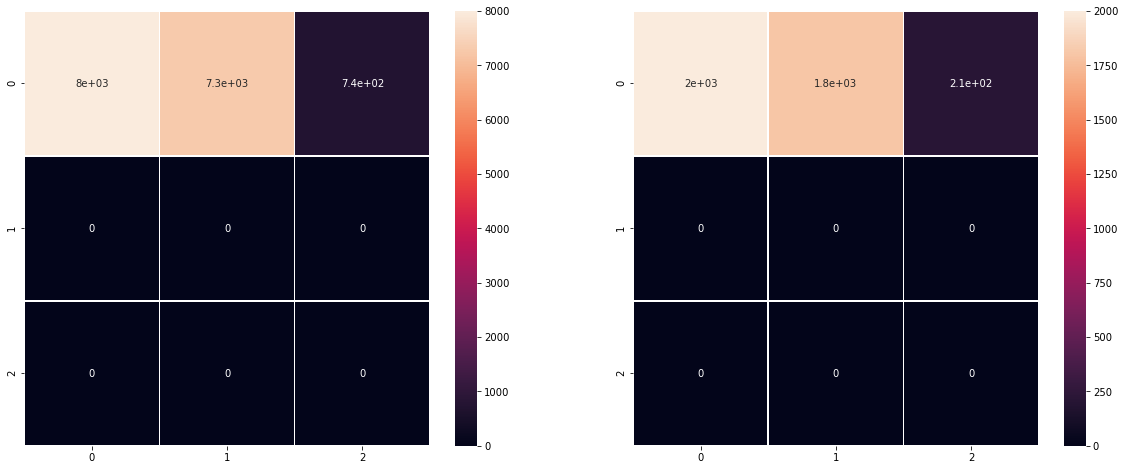

In [17]:
model = SVC(C = 0.01e-17,kernel = "linear")
model.fit(X_train,Y_train)
fig,ax = plt.subplots(1,2,figsize = (20,8))
print("Train Accuracy: ",model.score(X_train,Y_train)*100)
print("Test accuracy: ",model.score(X_test,Y_test)*100)
sns.heatmap(confusion_matrix(model.predict(X_train),Y_train),annot = True,linewidth = 0.5,ax = ax[0])
sns.heatmap(confusion_matrix(model.predict(X_test),Y_test),annot = True,linewidth = 0.5,ax = ax[1])


## Using rbf kernel
RBF kernel raises the gamma parameter to the negative [pwer euclidean distance of the features.<br>
This version also performs the same way as the first. As raising features to a higher degree does not yield any improvements<br>
Still stuck at baseline accuracy

Train Accuracy:  49.8628941792347
Test accuracy:  49.85044865403789


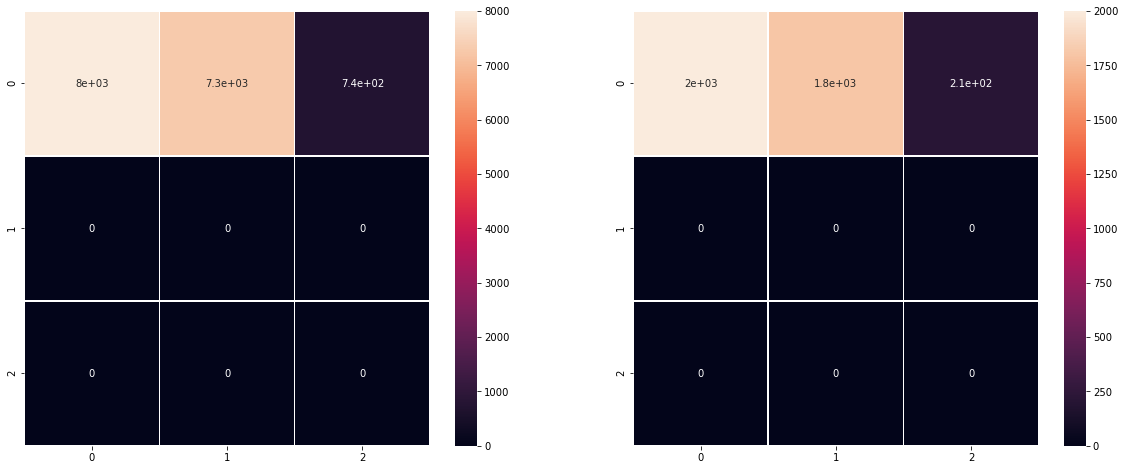

In [18]:
model = SVC(C = 0.01e-17,kernel = "rbf")
model.fit(X_train,Y_train)
fig,ax = plt.subplots(1,2,figsize = (20,8))
print("Train Accuracy: ",model.score(X_train,Y_train)*100)
print("Test accuracy: ",model.score(X_test,Y_test)*100)
sns.heatmap(confusion_matrix(model.predict(X_train),Y_train),annot = True,linewidth = 0.5,ax = ax[0])
sns.heatmap(confusion_matrix(model.predict(X_test),Y_test),annot = True,linewidth = 0.5,ax = ax[1])

## Using polynomial kernel
Polynomial basically multiplies features with each other after adding to a constant and raising to a degree "d" which is passed as a parameter.<br>
This version also performs the same way as the first. As raising features to a higher degree does not yield any improvements

Train Accuracy:  49.8628941792347
Test accuracy:  49.85044865403789


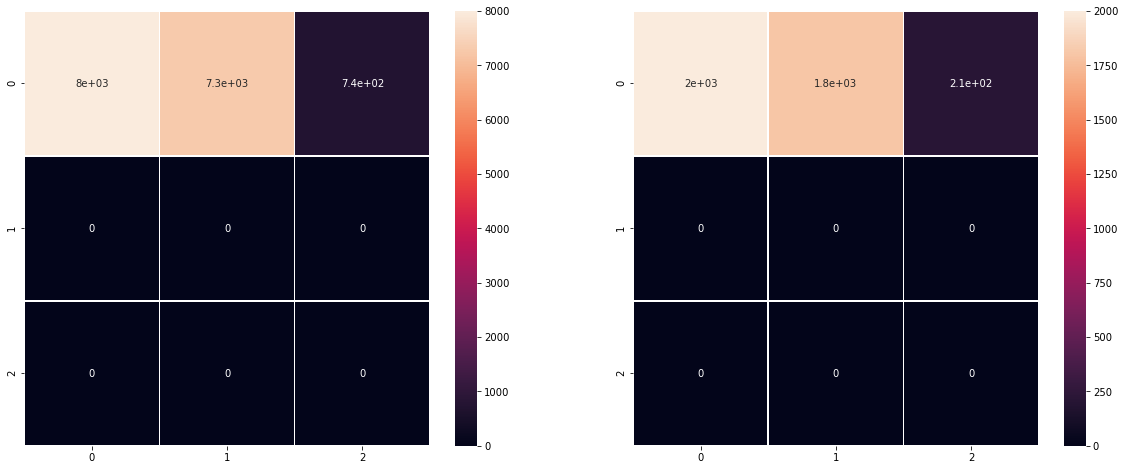

In [19]:
model = SVC(C = 0.01e-17,kernel = "poly")
model.fit(X_train,Y_train)
fig,ax = plt.subplots(1,2,figsize = (20,8))
print("Train Accuracy: ",model.score(X_train,Y_train)*100)
print("Test accuracy: ",model.score(X_test,Y_test)*100)
sns.heatmap(confusion_matrix(model.predict(X_train),Y_train),annot = True,linewidth = 0.5,ax = ax[0])
sns.heatmap(confusion_matrix(model.predict(X_test),Y_test),annot = True,linewidth = 0.5,ax = ax[1])

## Engineering more features
Visit : https://en.wikipedia.org/wiki/Algebraic_notation_(chess) <br>
We define functions that decode the "moves" column that contains the string of all the moves made in the game.<br>
An "x" implies a player captured another players peice.<br>
A "+" in the string implies there was a check that happened there.<br>
We count these two and create two new features.

In [20]:
def captures(x):
    count = 0
    for i in x.split():
        if "x" in i:
            count+=1
    return count
def checks(x):
    count = 0
    for i in x.split():
        if "+" in i:
            count+=1
    return count

## Adding new features to the cleaned data

In [21]:
data_X["captures"] = data["moves"].apply(captures)
data_X["checks"] = data["moves"].apply(checks)

## View new features distribution
These features contribute very little to the seperation. We continue the process of extracting features

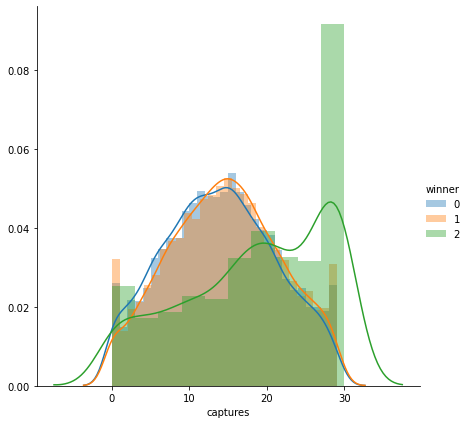

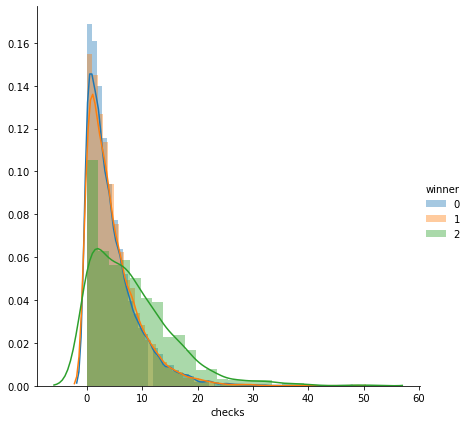

In [22]:
for col in ["captures","checks"]:
    g = sns.FacetGrid(pd.concat((data_X,data_Y),axis = 1),hue = "winner",height = 6)
    g.map(sns.distplot,col).add_legend()

## Encoding the moves
We encode the first five moves based on what peice was moved and where it was kept. <br>
So this gives us 10 more features<br>
Please go through the wikipedia link to find out how these functions work

In [23]:
pieces = {"K":1,"Q":2,"R":3,"B":4,"N":5}
files = {"a":1,"b":2,"c":3,"d":4,"e":5,"f":6,"g":7,"h":8}
def encode_pieces(x):
    features = list()
    text = x.split()
    for i in range(5):
        if i>=len(text):
            features.append(0)
        elif text[i][0] in pieces.keys():
            features.append(pieces[text[i][0]])
        else:
            features.append(6)
        #features.append(temp)
    return np.asarray(features)
def encode_moves(x):
    features = list()
    text = x.split()
    for i in range(5):
        if i>=len(text):
            features.append(0)
        elif text[i][0] in files.keys():
            features.append(files[text[i][0]])
        elif text[i][1] in files.keys():
            features.append(files[text[i][1]])
        elif text[i][2] in files.keys():
            features.append(files[text[i][2]])
        else:
            print("Error")
            break
        #features.append(temp)
    return np.asarray(features)


            



## Apply the functions to the "moves" attributes

In [24]:
features = data["moves"].apply(encode_pieces)

## Appending it to data

In [25]:
pi = list()
for j in range(5):
    pi.append([i[j] for i in features])


In [26]:
data_X["P1"],data_X["P2"],data_X["P3"],data_X["P4"],data_X["P5"] = pi

## Viewing distribution of new features
We get some seperation. These features are better.<br>
If we encode all of the moves we may be able to get better accuracy.<br>
We have to encode these features because we are using a SVM that mathematically computes using the features<br>
unlike a decision tree or random forest that works based on calculating the impurity factor based on class distribution using features

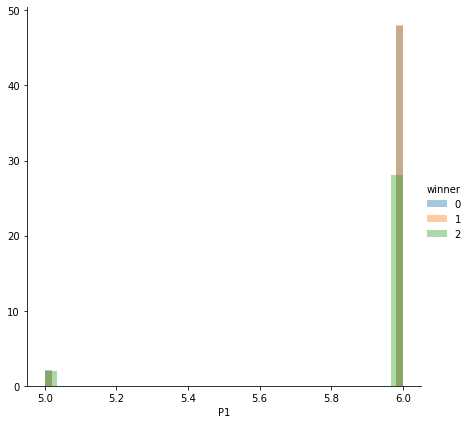

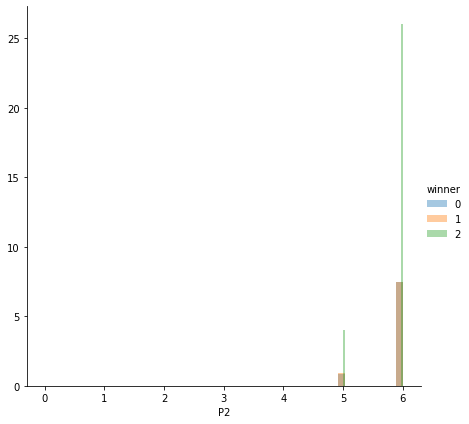

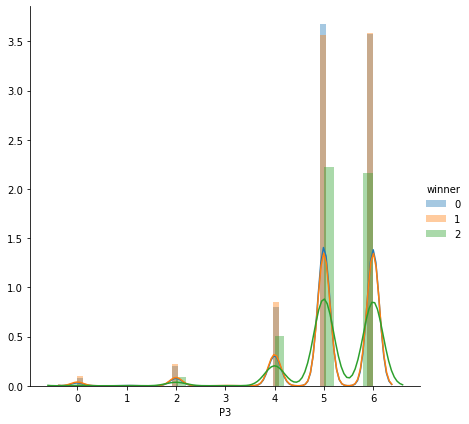

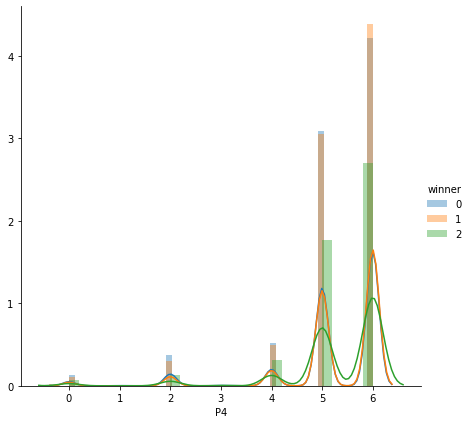

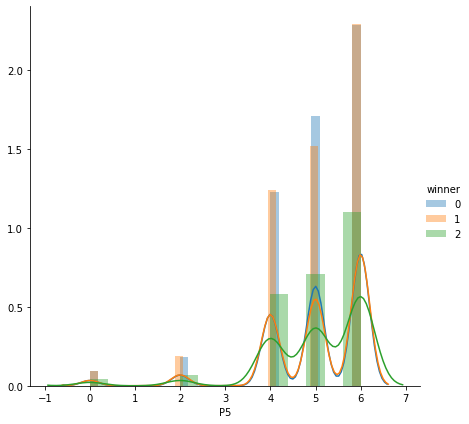

In [27]:
for col in ["P1","P2","P3","P4","P5"]:
    g = sns.FacetGrid(pd.concat((data_X,data_Y),axis = 1),hue = "winner",height = 6)
    g.map(sns.distplot,col).add_legend()

## Applying the moves function and appending to the data

In [28]:
moves = data["moves"].apply(encode_moves)

In [29]:
pi = list()
for j in range(5):
    pi.append([i[j] for i in moves])
data_X["M1"],data_X["M2"],data_X["M3"],data_X["M4"],data_X["M5"] = pi

## This is the final data that we will be using for classification

In [30]:
data_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   created_at      20058 non-null  float64
 1   last_move_at    20058 non-null  float64
 2   turns           20058 non-null  int64  
 3   victory_status  20058 non-null  int64  
 4   white_rating    20058 non-null  float64
 5   black_rating    20058 non-null  float64
 6   captures        20058 non-null  int64  
 7   checks          20058 non-null  int64  
 8   P1              20058 non-null  int64  
 9   P2              20058 non-null  int64  
 10  P3              20058 non-null  int64  
 11  P4              20058 non-null  int64  
 12  P5              20058 non-null  int64  
 13  M1              20058 non-null  int64  
 14  M2              20058 non-null  int64  
 15  M3              20058 non-null  int64  
 16  M4              20058 non-null  int64  
 17  M5              20058 non-null 

## Visualizing the new features
We see that this too adds some seperation<br>


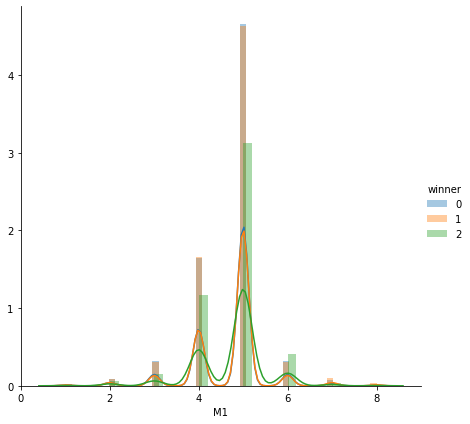

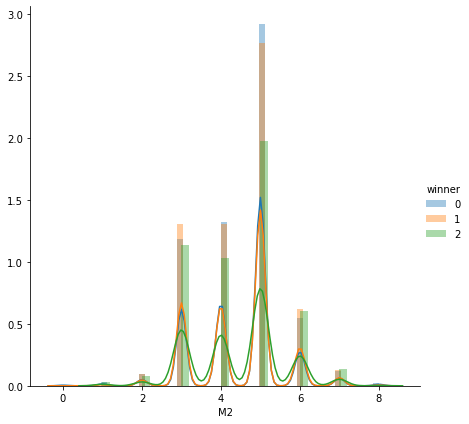

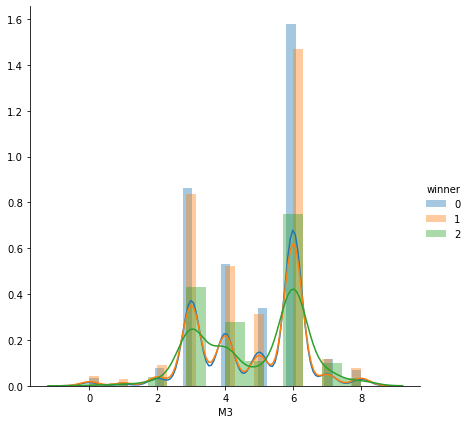

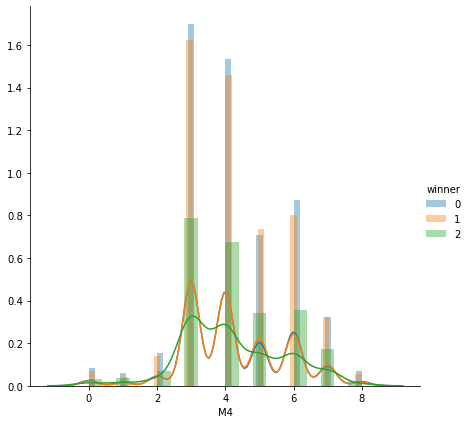

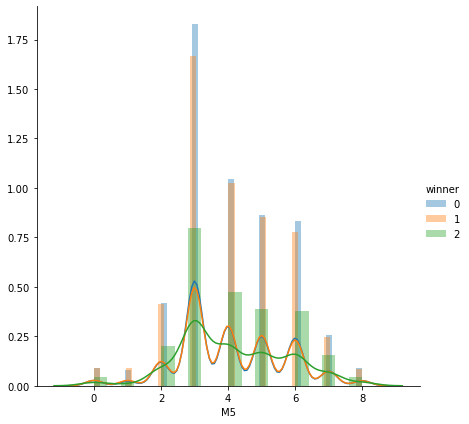

In [31]:
for col in ["M1","M2","M3","M4","M5"]:
    g = sns.FacetGrid(pd.concat((data_X,data_Y),axis =1),hue = "winner",height = 6)
    g.map(sns.distplot,col).add_legend()

## Seperating new data into train and test split

In [32]:
X_train,X_test,Y_train,Y_test = train_test_split(data_X,data_Y,test_size = 0.2)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(16046, 18) (16046,)
(4012, 18) (4012,)


## Using linear kernel. 
SVM does not scale well. It is inefficient and not good for large datasets. (like ours)

In [33]:
model = SVC(C = 5,kernel = "linear")
model.fit(X_train,Y_train)
fig,ax = plt.subplots(1,2,figsize = (20,8))
print("Train Accuracy: ",model.score(X_train,Y_train)*100)
print("Test accuracy: ",model.score(X_test,Y_test)*100)
sns.heatmap(confusion_matrix(model.predict(X_train),Y_train),annot = True,linewidth = 0.5,ax = ax[0])
sns.heatmap(confusion_matrix(model.predict(X_test),Y_test),annot = True,linewidth = 0.5,ax = ax[1])

KeyboardInterrupt: 

## Using RBF kernel
We get a 15% bump in our accuracy after using the more features and regularization

Train Accuracy:  66.96996136108687
Test accuracy:  65.6530408773679


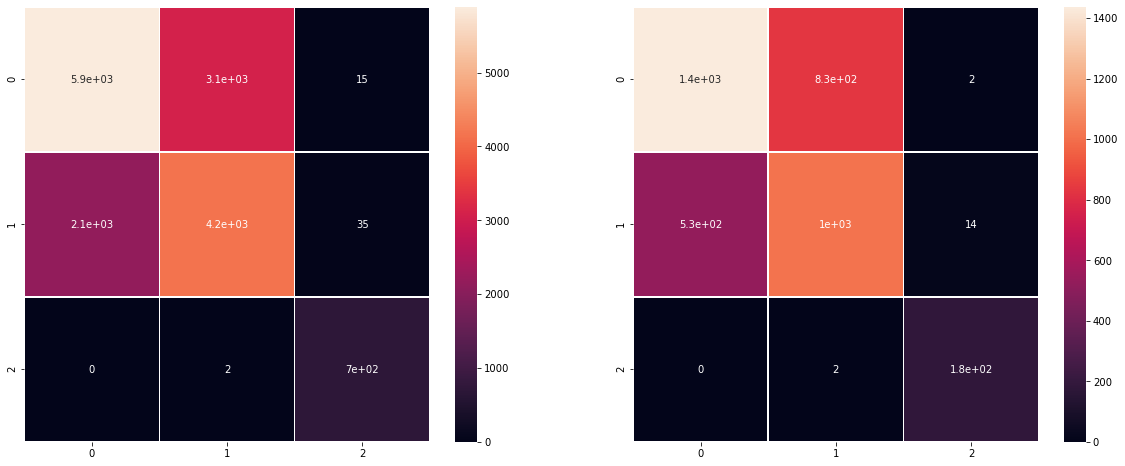

In [34]:
model = SVC(C = 10,kernel = "rbf")
model.fit(X_train,Y_train)
fig,ax = plt.subplots(1,2,figsize = (20,8))
print("Train Accuracy: ",model.score(X_train,Y_train)*100)
print("Test accuracy: ",model.score(X_test,Y_test)*100)
sns.heatmap(confusion_matrix(model.predict(X_train),Y_train),annot = True,linewidth = 0.5,ax = ax[0])
sns.heatmap(confusion_matrix(model.predict(X_test),Y_test),annot = True,linewidth = 0.5,ax = ax[1])

## Using Polynomial kernel
We get similar bump in accuracy but not as much as the RBF kernel


Train Accuracy:  60.956001495699866
Test accuracy:  59.89531405782652


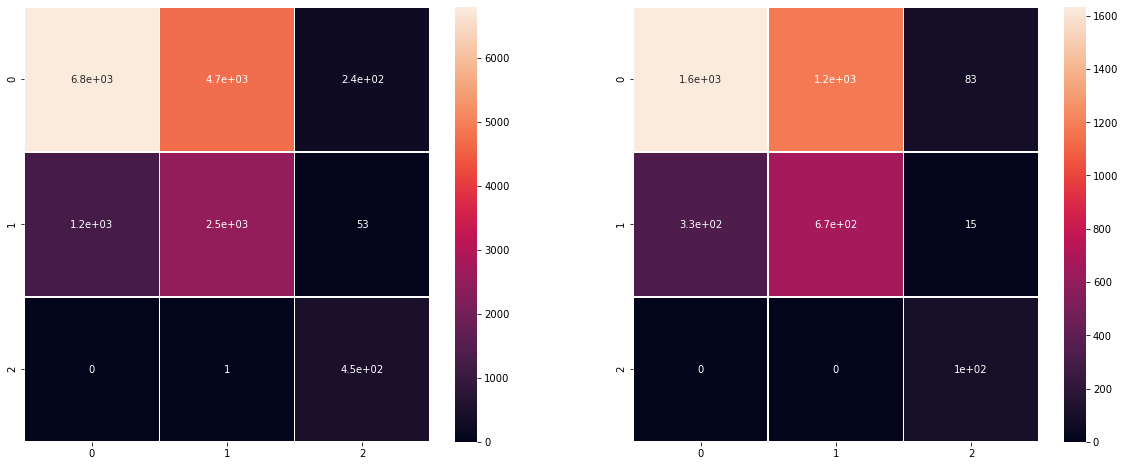

In [35]:
model = SVC(C = 10,kernel = "poly")
model.fit(X_train,Y_train)
fig,ax = plt.subplots(1,2,figsize = (20,8))
print("Train Accuracy: ",model.score(X_train,Y_train)*100)
print("Test accuracy: ",model.score(X_test,Y_test)*100)
sns.heatmap(confusion_matrix(model.predict(X_train),Y_train),annot = True,linewidth = 0.5,ax = ax[0])
sns.heatmap(confusion_matrix(model.predict(X_test),Y_test),annot = True,linewidth = 0.5,ax = ax[1])

## GridSearchCV
Grid search basically uses a grid (X-Y plane) and plots points on the grid. These two axes are basically the hyperparameters.<br>
This is a quadratic loop in case of two hyperparameters. So it does take some time.<br>
It does uniform searching based on the lists provided. So it does not randomly sample from the grid. Which would be more accurate but would cause performance issues.<br>
It returns the model that was trained using the best hyperparameters.

In [37]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}   
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1,n_jobs = -2) 
grid_fit = grid.fit(X_train, Y_train)
print(grid_fit.best_params_) 
print(grid_fit.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-2)]: Done 125 out of 125 | elapsed: 20.1min finished
{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.0001)


## Using GridSearchCV's returned SVM model
We see that this gives the best accuracy overall.<br>
If we encode all of the features from the moves attribute and also find a way to encode the starting tactics,<br>
it would greatly benefit the accuracy.

Train accuracy:  67.79882836844074
Test accuracy:  66.20139581256231


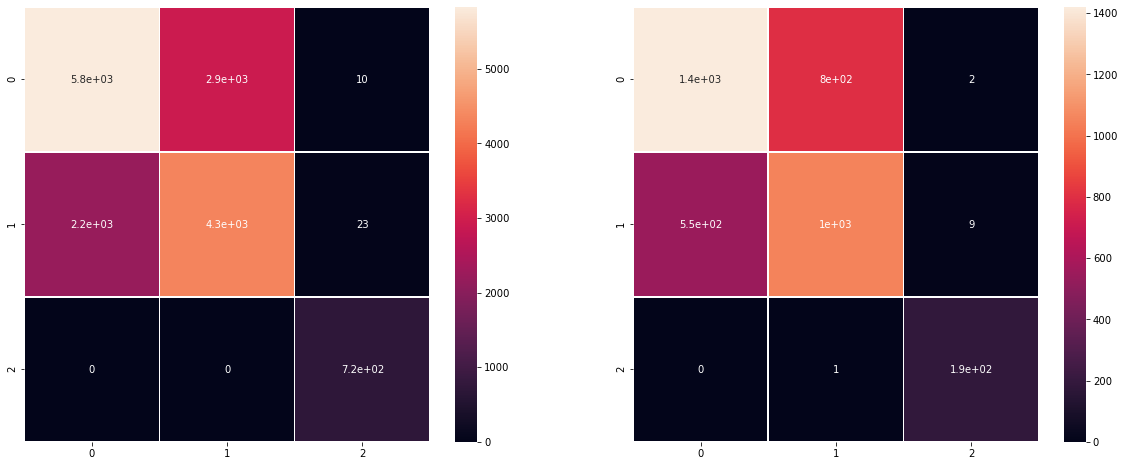

In [43]:
print("Train accuracy: ",grid_fit.score(X_train,Y_train)*100)
print("Test accuracy: ",grid_fit.score(X_test,Y_test)*100)
fig,ax = plt.subplots(1,2,figsize = (20,8))
sns.heatmap(confusion_matrix(grid_fit.predict(X_train),Y_train),annot = True,linewidth = 0.5,ax = ax[0])
sns.heatmap(confusion_matrix(grid_fit.predict(X_test),Y_test),annot = True,linewidth = 0.5,ax = ax[1])

<table>
<tr>
<th>#</th>
<th>Model</th>
<th>Data</th>
<th>Accuracy</th>
</tr>
<tr>
<td>1</td>
<td>SVM_Linear  </td>
<td>Original cleaned Data    </td>
<td>49.85</td>
</tr>
<tr>
<td>2</td>
<td>SVM_RBF    </td>
<td>Original cleaned Data    </td>
<td>49.85</td>
</tr>
<tr>
<td>3</td>
<td>SVM_Poly   </td>
<td>Original cleaned Data      </td>
<td>49.85</td>
</tr>
<tr>
<td>4</td>
<td>SVM_Linear_Regd    </td>
<td>Engineered cleaned Data     </td>
<td>NA</td>
</tr>
<tr>
<td>5</td>
<td>SVM_RBF_Regd   </td>
<td>Engineered cleaned Data    </td>
<td>69.65</td>
</tr>
<tr>
<td>6</td>
<td>SVM_Poly_Regd   </td>
<td>Engineered cleaned Data    </td>
<td>59.89</td>
</tr>
<td>7</td>
<td>SVM_RBF_GridSearchCV   </td>
<td>Engineered cleaned Data    </td>
<td>66.20</td>
</tr>
</table>

<center><h1>End of notebook</h1></center>